In [ ]:
# mounting your Google drive to this Colab browser environment
# you will see some warnings and be required to give permission to Colab to access your drive
from google.colab import drive
drive.mount('/content/gdrive')

# navigate to your Google drive
%cd gdrive/My Drive

In [ ]:
# clone, or copy, the notebook and required materials to your drive
! git clone https://github.com/kirana-bergstrom/artist-vs-machine

# navigate to the tutorial folder
! ls artist-vs-machine

In [ ]:
# install necessary requirements into this Colab environment
# this will result in a lot of text that can be ignored
! pip install -r requirements.txt

In [ ]:
# import required premade libraries
import os
import sys
from google.colab import output

# suppress unnecessary warnings, enable widgets, add environment paths
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib widget
output.enable_custom_widget_manager()

sys.path.append("/content/gdrive/MyDrive/artist-vs-machine/artist-vs-machine/code")

In [1]:
# import our own code
import draw
import utils
import check
import sketch_class
import preprocess

In [2]:
# global constants (do not change)
IMG_SIZE = 256  # image size, do not change

In [3]:
# global variables (can change if interested, but will change the results so do not do this before running the tutorial)
RANDOM_STATE = 10        # random state, change if a shuffle refresh of data is desired
MAX_N_PTS = 196          # drawing complexity, increase for greater complexity, decrease for faster training
NUM_PREPROCESSED = 1500  # number of preprocessed drawings to generate in each category
NUM_DATA = 1500          # number of training/testing/validation drawings to use in each category, must be <= NUM_PREPROCESSED

In [ ]:
# global parameters (can change if interested, but will change results)
train_split = 0.70       # percent of data to use for training
test_split = 0.15        # percent to use for testing
validation_split = 0.15  # percent to use for validation
batch_size = 64          # batch size for LSTM
epochs = 10              # number of epochs for LSTM

In [4]:
# preprocessed data and a pre-trained model are provided, if interested can change to True
to_preprocess = False   # if preprocessing data is desired
to_train = False        # if training model is desired

In [6]:
# shortnames for subfolders for convenience
data_dir = os.path.join(os.getcwd(), 'data')
model_dir = os.path.join(os.getcwd(), 'models')
preprocessed_data_dir = os.path.join(data_dir, 'preprocessed')
raw_data_dir = os.path.join(data_dir, 'raw')
student_data_dir = os.path.join(data_dir, 'student')

# Artist vs. the Machine:
## Can you beat an AI at Pictionary?

#### An interactive tutorial using Google's [Quick, Draw!](https://quickdraw.withgoogle.com/data) dataset

## What is Artificial Intelligence (AI)?

- What is Artificial Intelligence?
- Is AI as smart as humans?
- How do scientists use AI?

## What is image classification?

Using AI to label (or *classify*) an image.

#### Example:
Label the following pictures as either:
- cat
- dog
- bird
- cow

interactive(children=(ToggleButton(value=False, description='Label!'), Output()), _dom_classes=('widget-intera…

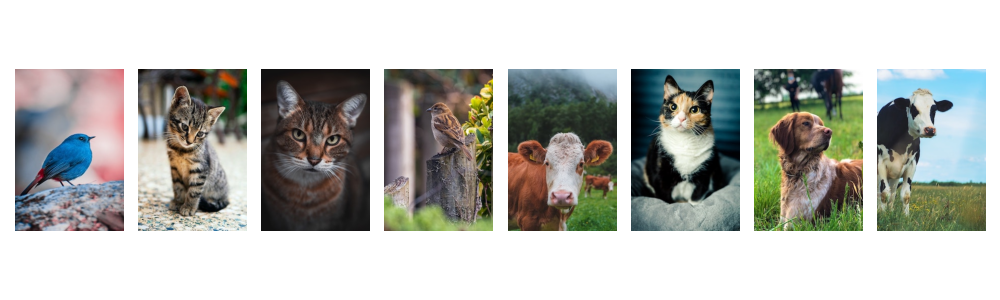

In [7]:
utils.image_grid_widget('images/animals', 8)

That was pretty easy - so what do we need AI for?

#### Example:
Label the following pictures as either:
- mallard duck
- pekin duck
- goose
- swan

interactive(children=(ToggleButton(value=False, description='Label!'), Output()), _dom_classes=('widget-intera…

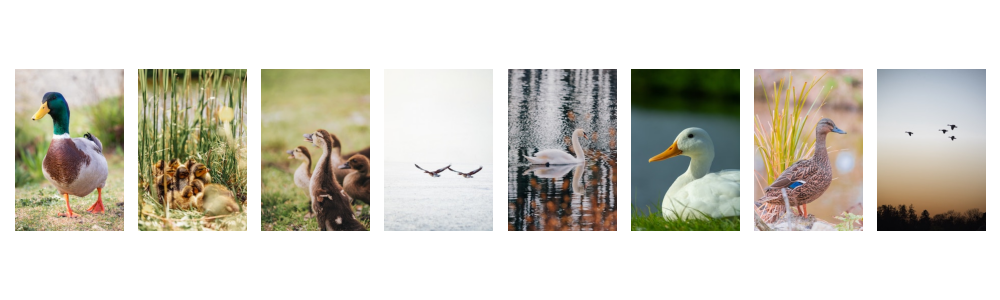

In [8]:
utils.image_grid_widget('images/birds', 8)

#### Discussion questions
- Why is this image classification problem so much harder than the last one?

## How are Pictionary and image classification similar?

In Pictionary, someone draws a picture...

![preview](images/preview.jpeg)

and everyone else tries to guess what they're drawing: also known as image classification!

## If humans can play Pictionary, can AI?

We are going to create a Pictionary-playing AI and name it **DAISY**: **D**rawing-classifying **A**rtificial **I**ntelligence for **S**cience-**Y** stuff.

In [9]:
AI_name = 'DAISY'

You may have heard of AIs that can do all sorts of complicated and difficult things, like playing chess or writing stories. These kinds of AIs take a lot of time to make.

We could try to make an AI that would actually play Pictionary with us, but we don't have a lot of time for this tutorial, and we can make a simple AI a lot faster than we can make a complicated one. 

So, we are going to limit DAISY to being able to play *weather Pictionary*: she'll only be able to identify drawings of a few different kinds of weather.

In [10]:
with open(os.path.join(os.getcwd(),'categories.txt')) as f:
    categories = [line.rstrip('\n') for line in f]

print('weather types:')
for c in categories:
    print(f'    {c}')

weather types:
    cloud
    hurricane
    lightning
    rain
    rainbow
    sun
    snowflake
    tornado


interactive(children=(ToggleButton(value=False, description='Label!'), Output()), _dom_classes=('widget-intera…

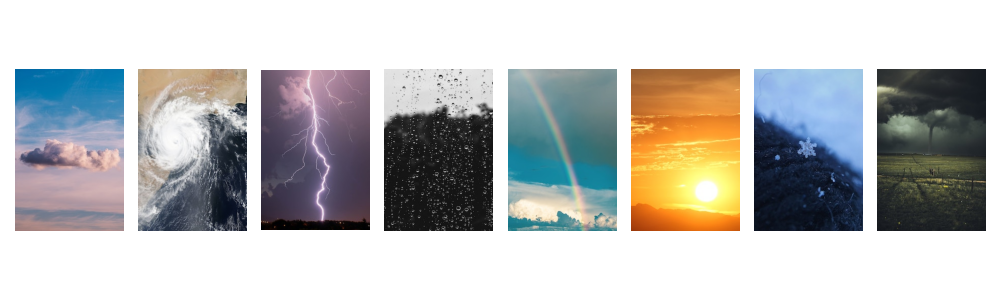

In [11]:
utils.image_grid_widget('images/weather', 8)

## How do we make an AI?

How did you learn what a cat looks like?

Think about all of the cats you have seen: in real life, in drawings, in movies, etc. 

In AI language, you have seen a lot of *data* on cats.

An AI is like a newborn baby. It needs to learn what objects are called by consuming data.

#### Discussion questions
- How do babies learn what objects are called?
- How would we do something similar for a computer (or for DAISY)?

## Data

We are going to show DAISY a bunch of drawings done by people online of each of our weather types, then tell her what each of these drawings is.

We'll use 1,500 images of each weather type: so 1,500 clouds, 1,500 hurricanes, etc.

In [12]:
preprocess.preprocess_raw_data(MAX_N_PTS, IMG_SIZE, raw_data_dir, preprocessed_data_dir,
                               NUM_PREPROCESSED, preprocess=to_preprocess, random_seed=RANDOM_STATE)

In [13]:
dataset = sketch_class.get_data(preprocessed_data_dir, NUM_DATA)

Now let's take a look at some of our data!

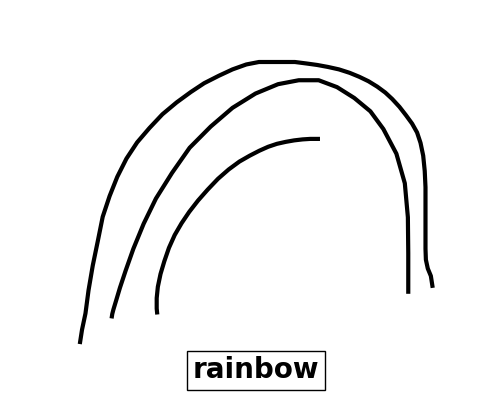

In [14]:
draw.draw(dataset, 'rainbow', index=4)

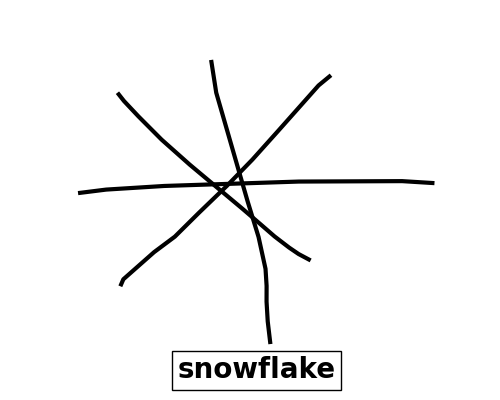

In [15]:
draw.draw(dataset, 'snowflake', index=1)

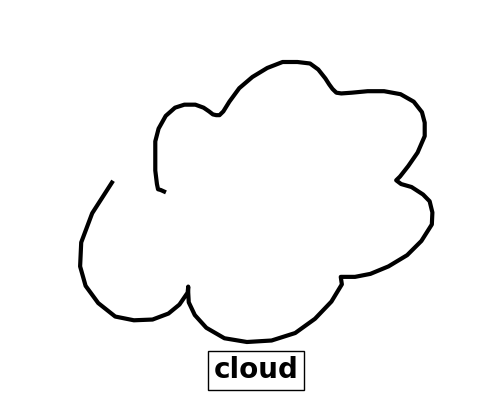

In [16]:
draw.draw(dataset, 'cloud', index=1)

Those were some pretty good drawings.

But if you've ever played Pictionary, you know that some people are better at drawing than others.

You also know that some things are harder to draw than others.

interactive(children=(Dropdown(description='Row:', options=(1, 2, 3, 4), value=None), Dropdown(description='Co…

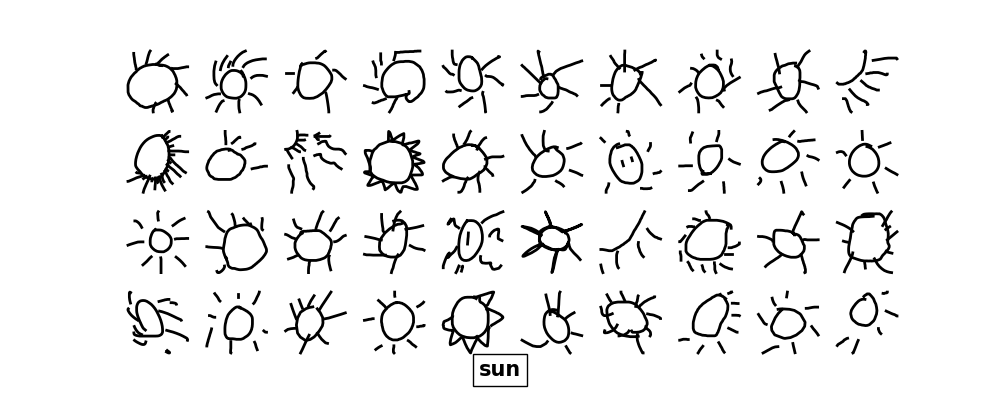

In [17]:
draw.draw_grid_widget(dataset, 'sun', n_rows=4, n_cols=10, start_index=0)

For the most part, these sun drawings are pretty good.

There's some weird ones (like the drawing in the **2**nd row, **3**rd column) but you could probably guess that most of these drawings are suns.

What about something that's a little harder to draw - like lightning?

interactive(children=(Dropdown(description='Row:', options=(1, 2, 3, 4), value=None), Dropdown(description='Co…

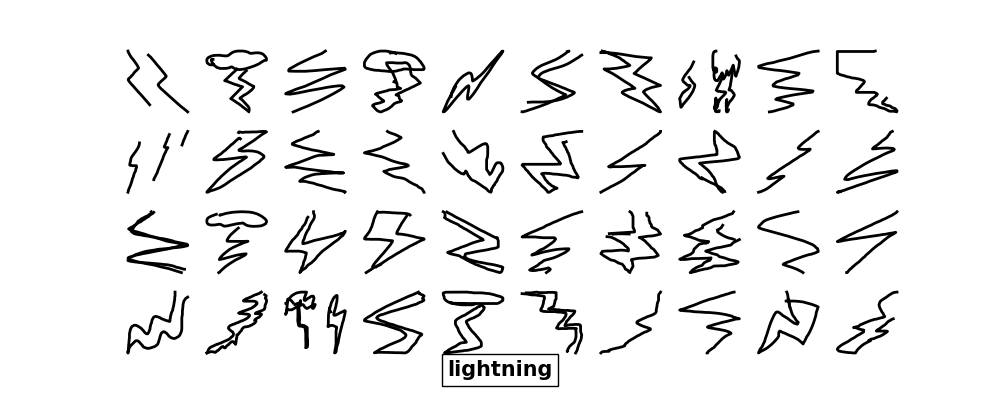

In [18]:
draw.draw_grid_widget(dataset, 'lightning', n_rows=4, n_cols=10, start_index=40)

Remember, DAISY is like a baby! She's never seen lightning before, all she knows about lightning are the drawings we are showing her.

If we show her a lot of bad drawings of lightning, she won't learn very well.

#### Discussion questions:

If you were playing Pictionary...
- What would you guess for the sketch in the **1**st row, **2**nd column?
- What would you guess for the sketch in the **2**nd row, **1**st column?

## Creating the AI

Next, we split up the data into *training* and *testing* data.

What does this mean?

Think about training data like homework, and testing data like tests.

We want to give DAISY different test problems than we gave her for homework, so we know that she can solve the problems (not just memorize the solutions!).

In [19]:
datasets, sizes = sketch_class.get_dataset_partitions(dataset, NUM_DATA*len(categories),
                                                      train_split=train_split,
                                                      test_split=test_split,
                                                      validation_split=validation_split)
train_dataset, validate_dataset, test_dataset = datasets
train_size, val_size, test_size = sizes

...and now for the exciting part! This is what it looks like to train an AI. Pretty simple, right?

In [20]:
DAISY = sketch_class.compile_and_fit_model(model_dir, AI_name, epochs, batch_size, MAX_N_PTS,
                                           train_dataset, validate_dataset, train_model=to_train)

## Testing our AI

Now that we have *trained* DAISY, onto the million dollar question: does our AI work? Is DAISY actually able to play weather Pictionary?

Let's test her! Remember, we saved some testing data to check and see if DAISY is working.

In [21]:
predict_labels = check.run_test(test_dataset, batch_size, MAX_N_PTS, DAISY)

29/29 [==============================] - 11s 63ms/step


interactive(children=(ToggleButton(value=False, description='DAISY says...'), Output()), _dom_classes=('widget…

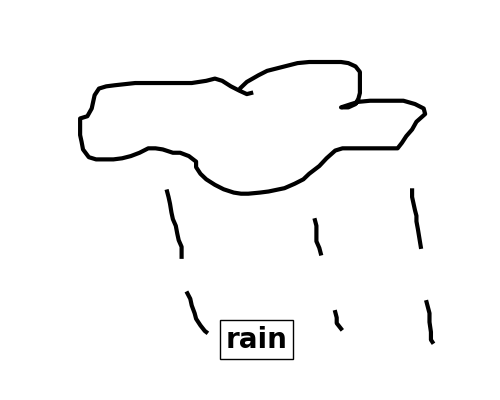

In [22]:
draw.draw_and_label_widget(18, test_dataset, predict_labels)

That one works! The artist said it was a rainbow, and DAISY thinks it's a rainbow. Let's try a few more:

interactive(children=(ToggleButton(value=False, description='DAISY says...'), Output()), _dom_classes=('widget…

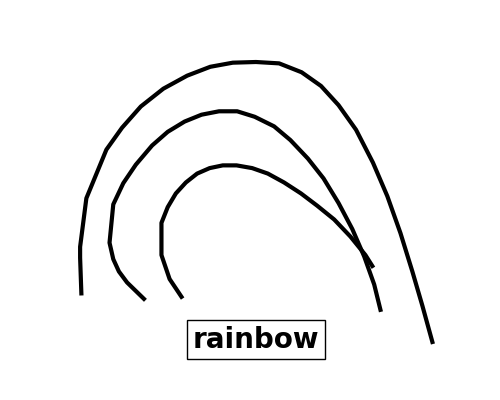

In [23]:
draw.draw_and_label_widget(21, test_dataset, predict_labels)

interactive(children=(ToggleButton(value=False, description='DAISY says...'), Output()), _dom_classes=('widget…

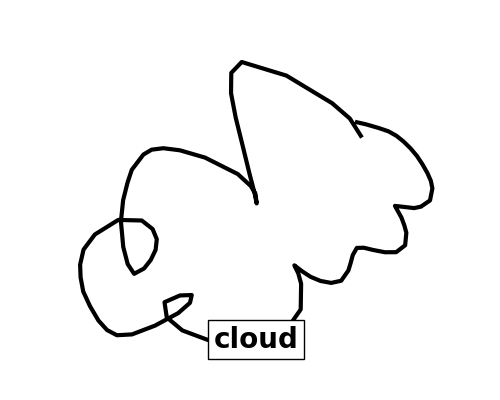

In [24]:
draw.draw_and_label_widget(4, test_dataset, predict_labels)

So far, DAISY is doing pretty good! Let's see if we can find a drawing that she gets wrong.

interactive(children=(ToggleButton(value=False, description='DAISY says...'), Output()), _dom_classes=('widget…

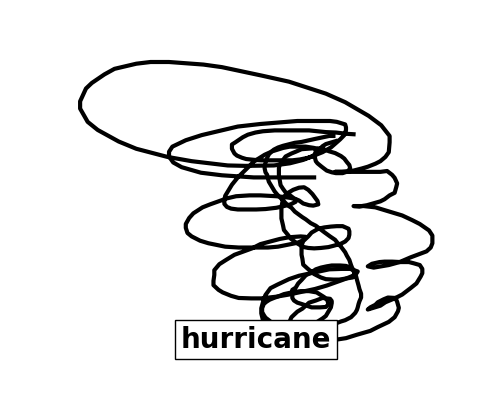

In [25]:
draw.draw_and_label_widget(3, test_dataset, predict_labels)

#### Discussion questions:

- What would *you* label this sketch as?
- Why does DAISY get confused by this sketch?

Those were some specific examples of sketches DAISY did well at.

If we were giving DAISY a test on her Pictionary-playing abilities, what grade would she get?

In [26]:
check.print_grades(test_dataset, predict_labels, 'total')

TOTAL      test grade :  89.00%
                         B+


DAISY labeled around 89% of the drawings on her test correctly, so she gets a grade of B. That's pretty good!

But remember, some things are harder to draw than others. For example, it seems like suns were easy to draw and lightning is harder.

Let's break up DAISY's grade into the different categories: what grade would she have gotten if we only tested her only on sun drawings? Or on just lightning drawings?

In [27]:
check.print_grades(test_dataset, predict_labels)

CLOUD      test grade : 98.75%
                        A

HURRICANE  test grade : 76.55%
                        C

LIGHTNING  test grade : 81.50%
                        B-

RAIN       test grade : 89.52%
                        B+

RAINBOW    test grade : 97.47%
                        A

SUN        test grade : 96.07%
                        A

SNOWFLAKE  test grade : 94.09%
                        A

TORNADO    test grade : 75.57%
                        C



### Discussion questions:

- What categories of drawings is DAISY good at guessing?
- What categories of drawings is DAISY bad at guessing?

Let's take a closer look at her test and see if we can figure out why she has a hard time with hurricanes.

She only got 75% of the hurricane drawings correct. What was she guessing for the other 25%?

In [28]:
check.category_report('hurricane', test_dataset, predict_labels)

number of...
    HURRICANE drawings DAISY thought were CLOUD drawings:     0
    HURRICANE drawings DAISY thought were LIGHTNING drawings: 0
    HURRICANE drawings DAISY thought were RAIN drawings:      1
    HURRICANE drawings DAISY thought were RAINBOW drawings:   2
    HURRICANE drawings DAISY thought were SUN drawings:       0
    HURRICANE drawings DAISY thought were SNOWFLAKE drawings: 0
    HURRICANE drawings DAISY thought were TORNADO drawings:   50


DAISY never guesses that hurricane drawings are suns, but she incorrectly labeled 50 hurricane drawings as tornados.

Let's look at some of the hurricane drawings she got confused for tornados.

interactive(children=(Dropdown(description='category:', options=('cloud', 'lightning', 'rain', 'rainbow', 'sun…

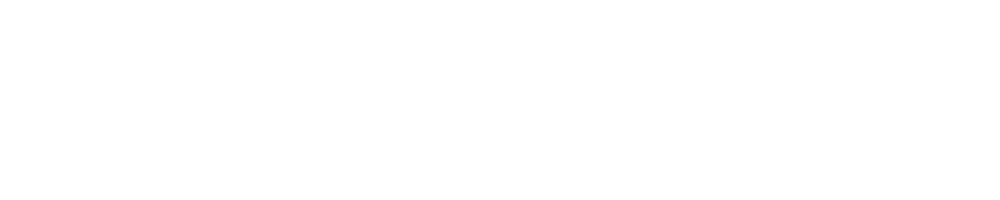

In [29]:
draw.draw_misclassification_grid(test_dataset, predict_labels, 'hurricane')

### Discussion questions:

- What would you guess for these drawings: tornado or hurricane?

DAISY also got a B- in the lightning category. Let's take a closer look at what she was guessing for lightning.

In [30]:
check.category_report('lightning', test_dataset, predict_labels)

number of...
    LIGHTNING drawings DAISY thought were CLOUD drawings:     1
    LIGHTNING drawings DAISY thought were HURRICANE drawings: 6
    LIGHTNING drawings DAISY thought were RAIN drawings:      19
    LIGHTNING drawings DAISY thought were RAINBOW drawings:   0
    LIGHTNING drawings DAISY thought were SUN drawings:       1
    LIGHTNING drawings DAISY thought were SNOWFLAKE drawings: 7
    LIGHTNING drawings DAISY thought were TORNADO drawings:   3


So DAISY often gets lightning confused with rain. Let's look at some of the drawings she guessed wrong to see if we can figure out why.

interactive(children=(Dropdown(description='category:', options=('cloud', 'hurricane', 'rain', 'rainbow', 'sun…

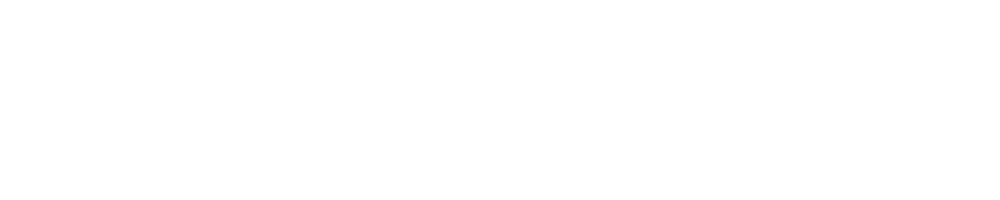

In [31]:
draw.draw_misclassification_grid(test_dataset, predict_labels, 'lightning', index=3)

### Discussion questions:

- Why do you think DAISY gets lightning and rain confused so often?

## DAISY's next best guesses

When you're playing Pictionary, you're not limited to just one guess! You might be 90% sure that someone is drawing a dog, but 10% of you thinks it *might* be a cat.

Below we have DAISY look at some of the same drawings we looked at above to see what she's thinking.

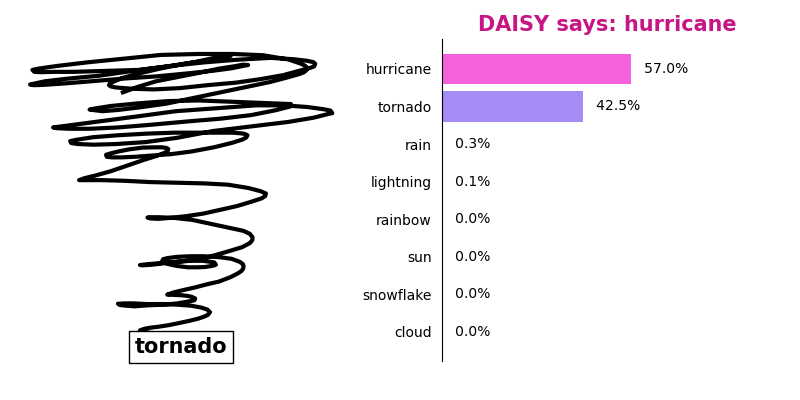

In [32]:
draw.draw_label_probs(test_dataset, predict_labels, 'tornado', index=2)

This is a drawing of tornado that DAISY thinks is a hurricane.

But if we look at her next best guesses in the chart to the right, we can see that she's only 57% confident the drawing is a hurricane.

Her next best guess is tornado, which is the right answer.

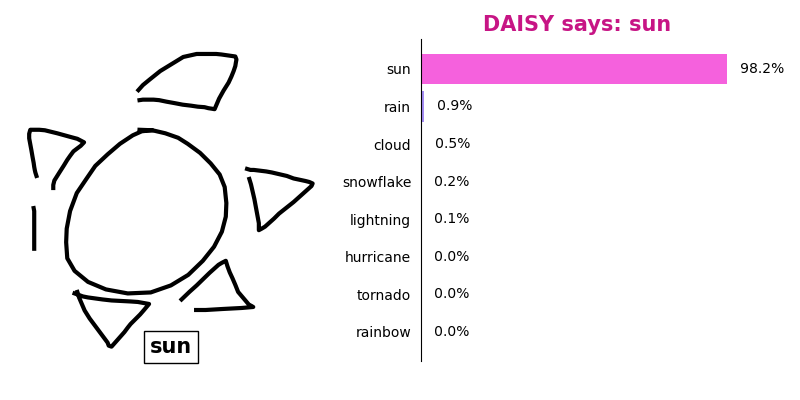

In [33]:
draw.draw_label_probs(test_dataset, predict_labels, 'sun', index=4)

Sometimes she is VERY confident in her answers.

This is a drawing of a sun, and she's 98% sure it's a sun.

## OK, let's play Pictionary!

Now for the fun part! We're going to actually play Pictionary with DAISY.

1. **IMPORTANT: open another browser window or tab before doing steps 2-4!** Complete these steps in the other window so you still have this page open to follow along with the directions.
  
2. Navigate to: [https://sketch.io/sketchpad/](https://sketch.io/sketchpad/). Close out of (click the red "x") on the "Welcome to Sketchpad" window pop-up.

<img src="images/sketchpad_window.png" style="margin:auto;width:400px">

3. Make sure the pencil drawing tool is selected (it will be highlighted yellow by default) and start to draw! Remember, in Pictionary speed is a factor, so keep your drawings quick and simple - nothing too complicated, or DAISY will get confused. **Don't use colors, or other drawing tools other than the pencil.**

<img src="images/pencil_tool.png" style="margin:auto;width:400px">

4. When you are done with your drawing, click "Export" in the toolbar on the lower left of your screen:

<img src="images/export.png" style="width:400px;margin:auto">

then "Download .SVG":

<img src="images/svg.png" style="width:400px;margin:auto">

This will save a file to your computer. Remember the location where you save it (probably the "Downloads" folder) and the name (it will be called "Drawing" by default).

**Now you can close the browser window you opened in step 1. All remaining steps will be completed in this window.**

5. In the toolbar on the left side of this window, click on the "File Browser" icon to open the navigation pane.

<img src="images/file_browser.png" style="width:400px;margin:auto">

6. Double click on the "data" folder, then the "student" folder.

<img src="images/data_directory.png" style="width:400px;margin:auto">
<img src="images/student_directory.png" style="width:400px;margin:auto">

7. You'll see folders for each weather category. Double click on the category that you drew. You'll see at least one file already in the directory called "1.svg".

<img src="images/category_directory.png" style="width:400px;margin:auto">

8. Upload your drawing to this folder by clicking the "Upload" up array button, navigating to your drawing in the window that pops up and double clicking on it.

<img src="images/upload_button.png" style="width:400px;margin:auto">
<img src="images/to_upload.png" style="width:400px;margin:auto">

9. Once your drawing is uploaded, right click on it, and rename it as the next number file. So for example, if there was just a file named "1.svg" in the folder, you'll rename yours to "2.svg". If there was already a "2.svg" in the folder, name yours as "3.svg", etc.

<img src="images/rename_item.png" style="width:400px;margin:auto">
<img src="images/after_rename.png" style="width:400px;margin:auto">

10. Run the next code cell and select the category you drew and the number of your drawing!

In [34]:
sketch_class.student_predict_and_plot(student_data_dir, MAX_N_PTS, IMG_SIZE, DAISY, batch_size)

interactive(children=(Dropdown(description='category:', options=('cloud', 'hurricane', 'lightning', 'rain', 'r…

## How can we use AIs like DAISY in atmospheric science?

DAISY might not be very useful in atmospheric science - we don't often need to play Pictionary when we're predicting the weather!

But similar image classification AIs are VERY useful to us and are being developed and used by scientists all around the world to:
- help predict the weather
- understand climate change
- reduce damage from natural disasters
- and many more!

## Cloud identification

You may know that there are different kinds of clouds.

interactive(children=(ToggleButton(value=False, description='Label!'), Output()), _dom_classes=('widget-intera…

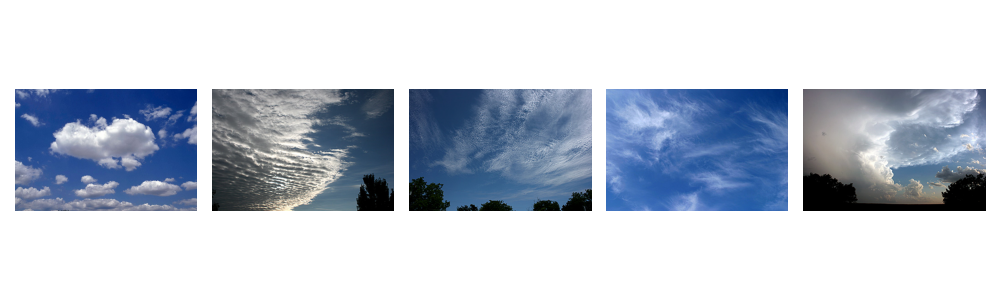

In [35]:
utils.image_grid_widget('images/clouds', 5)

Cumulonimbus clouds often show up right before tornados.

#### Discussion questions:

- Why would you want to know the difference between a cumulonimbus and a cumulus cloud?
- Do you think an AI algorithm would be better than a trained meteorologist (weather scientist) at telling the difference?

## Wildfire smoke vs. clouds

Wildfires can happen when lightning hits a tree and it catches on fire, then the fire starts spreading.

If it happens in the forest, it might take a long time before people know a wildfire is happening.

Satellites are constantly taking pictures of the Earth from space. Satellites take millions of pictures of the Earth every day!

interactive(children=(ToggleButton(value=False, description='Label!'), Output()), _dom_classes=('widget-intera…

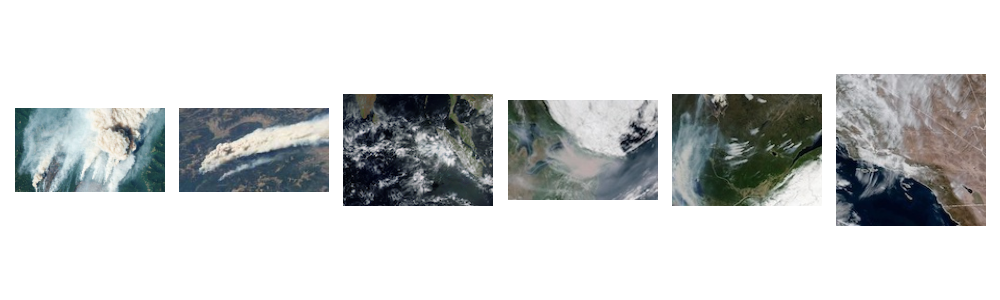

In [36]:
utils.image_grid_widget('images/smoke', 6)

Here's some examples of what wildfire smoke vs. clouds look like from satellite pictures.

#### Discussion questions:

- Why it would be useful to tell the difference between smoke and a cloud from space?
- Why wouldn't we just have humans look at all the satellite images?

## Final discussion

- Is it difficult to make an AI to do image classification? What are some of the problems we had making DAISY?
- How are AIs like DAISY useful in atmospheric science?